In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import MultipleLocator
import seaborn as sns; sns.set()
sns.__version__

'0.11.1'

In [2]:
sns.set_style("ticks", {"xtick.major.size":15,"ytick.major.size":15})

plt.rc('font', family='DejaVu Sans') 
# This should be replaced with Helvetica; 
# See https://stackoverflow.com/questions/42097053/matplotlib-cannot-find-basic-fonts
plt.rcParams['pdf.fonttype'] = 42

%config InlineBackend.figure_format = 'retina'

In [3]:
df_pair_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_pair_1985_2009.pkl")
df_paper_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_paper_1985_2009.pkl")
df_grant_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_grant_1985_2009.pkl")

In [4]:
import pickle

with open('/data/interdisciplinarity/df_paper_grant_stat.pkl', 'rb') as f:
    df_paper_grant_stat = pickle.load(f)
    
with open('/data/interdisciplinarity/df_c_from_own_fos.pkl', 'rb') as f:
    df_c_from_own_fos = pickle.load(f)

In [5]:
# Source: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
# Produces count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   conf_interval: the percent range of the confidence interval (default is 95%)

import scipy as sp
from scipy.stats import t

def summarySE(data, measurevar, groupvars, conf_interval=0.95):
    def std(s):
        return np.std(s, ddof=1)
    def stde(s):
        return std(s) / np.sqrt(len(s))
    def ci(s):
        # Confidence interval multiplier for standard error
        # Calculate t-statistic for confidence interval: 
        # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
        ciMult = t.ppf(conf_interval/2.0 + .5, len(s)-1)
        return stde(s)*ciMult
    def ciUpper(s):
        return np.mean(s)+ci(s)
    def ciLower(s):
        return np.mean(s)-ci(s)
    
    data = data[groupvars+measurevar].groupby(groupvars).agg([len, np.mean, std, stde, ciUpper, ciLower, ci])

    data.reset_index(inplace=True)

    data.columns = groupvars+['_'.join(col).strip() for col in data.columns.values[len(groupvars):]]

    return data

## US

In [6]:
df_pair = df_pair_1985_2009[df_pair_1985_2009["funder_countries"]=="US"]
df_grant = df_grant_1985_2009[df_grant_1985_2009["funder_countries"]=="US"]

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'
df_pair['mag_id'] = df_pair['mag_id'].astype(str)

In [19]:
#####----- A -----#####
df_tmp = df_pair[['grant_id','funding_usd','grant_interdisciplinarity_interval']].drop_duplicates()
funding_per_grantITD_US = summarySE(df_tmp, ['funding_usd'], ['grant_interdisciplinarity_interval'])


import statsmodels.api as sm

X = sm.add_constant(df_tmp['grant_interdisciplinarity_interval'])
ols_model = sm.OLS(df_tmp['funding_usd'], X, missing='drop')
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

pred = est.get_prediction(X).summary_frame()
pred['grant_interdisciplinarity_interval'] = df_tmp['grant_interdisciplinarity_interval']
pred['ci'] = pred['mean_se']*1.96
pred_y_US = summarySE(pred, ['mean'], ['grant_interdisciplinarity_interval'])
pred_ci_US = summarySE(pred, ['mean_se'], ['grant_interdisciplinarity_interval'])

In [9]:
#####----- B -----#####
df_tmp = df_pair[['interdisciplinarity_reference','interdisciplinarity_citation','grant_interdisciplinarity_interval']]
paperRefITD_per_grantITD_US = summarySE(df_tmp, ['interdisciplinarity_reference'], ['grant_interdisciplinarity_interval'])
paperCitITD_per_grantITD_US = summarySE(df_tmp, ['interdisciplinarity_citation'], ['grant_interdisciplinarity_interval'])

In [10]:
#####----- C -----#####
df_tmp = df_grant[['grant_id','grant_interdisciplinarity_interval','num_paper']].drop_duplicates()
numPaper_per_grantITD_US = summarySE(df_tmp, ['num_paper'], ['grant_interdisciplinarity_interval'])

In [11]:
#####----- D -----#####
df_tmp = df_pair[['grant_interdisciplinarity_interval','interdisciplinarity_reference_interval',
                  'c_hit_rate_5_lvl-0']].groupby(['grant_interdisciplinarity_interval',
                                                  'interdisciplinarity_reference_interval'], as_index=False).mean()
df_heatmap_US = df_tmp.pivot('interdisciplinarity_reference_interval','grant_interdisciplinarity_interval',
                              'c_hit_rate_5_lvl-0')

df_heatmap_US.sort_index(level=0, ascending=False, inplace=True)

In [12]:
#####----- E -----#####
df_tmp = df_paper_grant_stat[(((df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==25)|
                               (df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==100)) &
                              ((df_paper_grant_stat['interdisciplinarity_reference_quartile']==25)|
                               (df_paper_grant_stat['interdisciplinarity_reference_quartile']==100)))].copy()

df_tmp[['mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']] = df_tmp[['mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']].astype(str)
df_tmp['label_avg_grant_itd_n_paper_itd'] = df_tmp[['mean_grant_interdisciplinarity_quartile',
                                                    'interdisciplinarity_reference_quartile']].agg('&'.join, axis=1)

df_tmp = df_tmp[df_tmp['mag_id'].isin(df_pair['mag_id'])]

df_c_from_own_fos['mag_id'] = df_c_from_own_fos['mag_id'].astype(str)
df_tmp = pd.merge(df_c_from_own_fos, df_tmp, on='mag_id')

df_tmp = df_tmp[['label_io', 'c_from_own_fos', 'label_avg_grant_itd_n_paper_itd',
                 'mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']]

c_per_grantITD_paperITD_FromOwnField_US = summarySE(df_tmp, ['c_from_own_fos'],
                                                     ['label_io','label_avg_grant_itd_n_paper_itd'])

df_rand = summarySE(df_tmp, ['c_from_own_fos'], ['label_io'])
rand_inside_US = float(df_rand[df_rand['label_io']=='Inside']['c_from_own_fos_mean'])
rand_outside_US = float(df_rand[df_rand['label_io']=='Outside']['c_from_own_fos_mean'])

<ipython-input-72-1a731578f954>:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


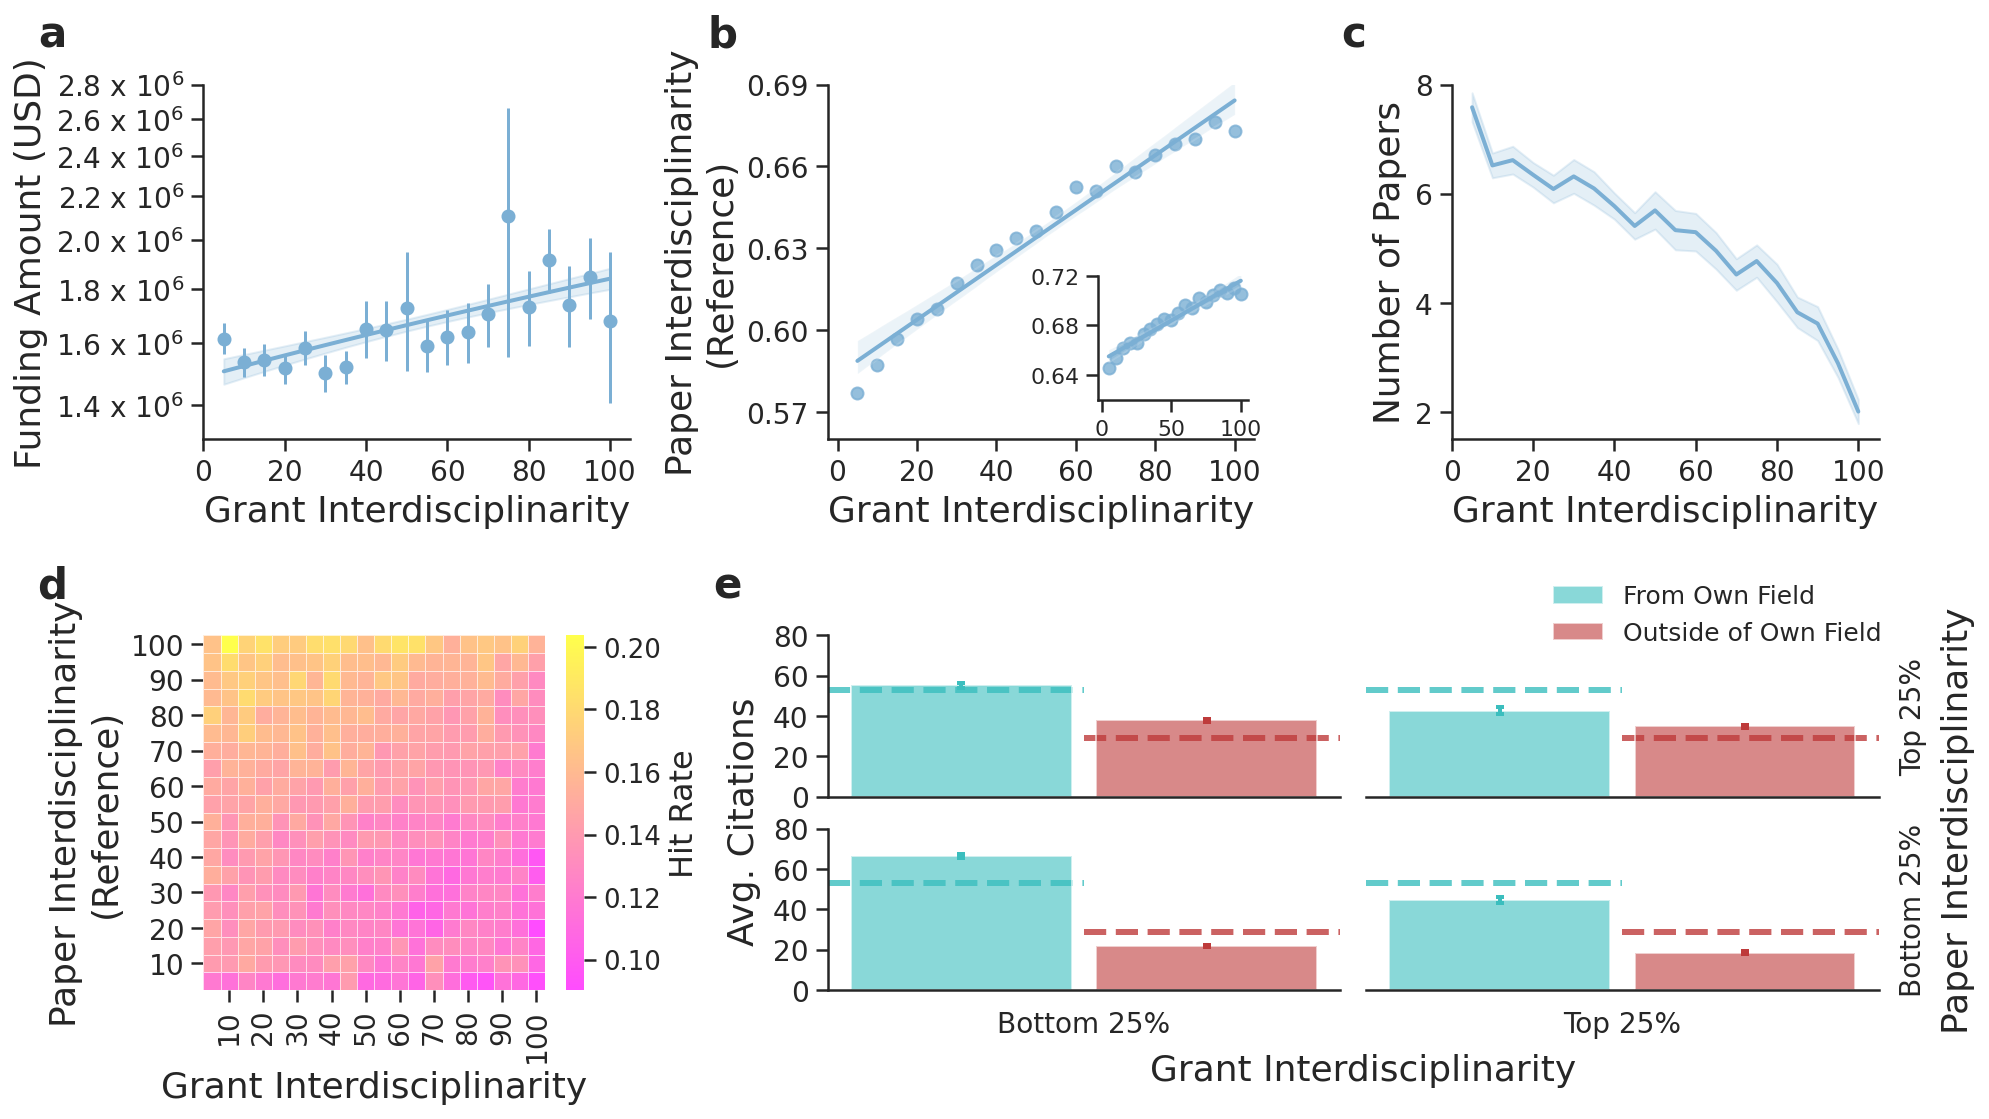

In [72]:
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['agg.path.chunksize'] = 10000

fig = plt.figure(figsize=(14,8))
gs = GridSpec(2, 3, figure=fig)

#####----- A -----#####
ax = fig.add_subplot(gs[0,0])

x1 = funding_per_grantITD_US['grant_interdisciplinarity_interval']
mu1 = funding_per_grantITD_US['funding_usd_mean']
ci1 = funding_per_grantITD_US['funding_usd_ci']
ax.errorbar(x1, mu1, yerr=ci1, fmt='o', color='#7bafd4')

x2 = pred_y_US['grant_interdisciplinarity_interval']
mu2 = pred_y_US['mean_mean']
ci2 = pred_ci_US['mean_se_mean']
ax.plot(x2, mu2, lw=2, color='#7bafd4')
ax.fill_between(x2, mu2+ci2, mu2-ci2, alpha=0.2, color='#7bafd4')

ax.set_ylabel('Funding Amount (USD)', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.yticks([1.4*10**6, 1.6*10**6, 1.8*10**6, 2.0*10**6, 2.2*10**6, 2.4*10**6, 2.6*10**6, 2.8*10**6])
ax.set_yticklabels(['1.4 x $10^6$', '1.6 x $10^6$', '1.8 x $10^6$', '2.0 x $10^6$', 
                    '2.2 x $10^6$', '2.4 x $10^6$', '2.6 x $10^6$', '2.8 x $10^6$'])
plt.ylim(1.3*10**6, 2.8*10**6)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.32, 1.2, 'a', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- B -----#####
ax = fig.add_subplot(gs[0,1])

ax = sns.regplot(ax=ax, x='grant_interdisciplinarity_interval', y='interdisciplinarity_reference_mean',
                 line_kws={'linewidth':2}, color='#7bafd4', data=paperRefITD_per_grantITD_US)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.gca().yaxis.set_major_locator(MultipleLocator(0.03))
plt.ylim(0.56, 0.69)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(-2.5, 105)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axins = inset_axes(ax, width="35%", height="35%", loc=4, 
                   bbox_to_anchor=(0.01,0.08,1,1), bbox_transform=ax.transAxes)
axins = sns.regplot(ax=axins, x='grant_interdisciplinarity_interval', y='interdisciplinarity_citation_mean', 
                    line_kws={'linewidth':2}, color='#7bafd4', data=paperCitITD_per_grantITD_US)
axins.set_ylabel('')
axins.set_xlabel('')

plt.gca().yaxis.set_major_locator(MultipleLocator(0.04))
plt.ylim(0.62, 0.72)
plt.gca().xaxis.set_major_locator(MultipleLocator(50))
plt.xlim(-2.5, 105)
    
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'b', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- C -----#####
ax = fig.add_subplot(gs[0,2])

x = numPaper_per_grantITD_US['grant_interdisciplinarity_interval']
mu = numPaper_per_grantITD_US['num_paper_mean']
ci = numPaper_per_grantITD_US['num_paper_ci']

ax.plot(x, mu, lw=2, color='#7bafd4')
ax.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#7bafd4')

plt.gca().yaxis.set_major_locator(MultipleLocator(2))
plt.ylim(1.5, 8.0)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)

ax.set_ylabel('Number of Papers', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.2, 1.2, 'c', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- D -----#####
ax = fig.add_subplot(gs[1,0])

f1 = lambda x: None
f2 = lambda x: x
ax = sns.heatmap(df_heatmap_US, cmap='spring', linewidth=0.5, alpha=0.7,
                 #xticklabels=[f(x) for x in range(10,100+1,10) for f in (f1,f2)],
                 #yticklabels=[f(x) for x in range(100,10-1,-10) for f in (f2,f1)],
                 cbar_kws={'label': 'Hit Rate'})

ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=90)
ax.set_xticks(np.arange(0, df_heatmap_US.shape[0], 2)+1.5)
ax.set_yticks(np.arange(0, df_heatmap_US.shape[0], 2)+0.5)
ax.set_xticklabels([x for x in range(10,100+1,10)])
ax.set_yticklabels([x for x in range(100,10-1,-10)])

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.text(-0.4, 1.2, 'd', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- E -----#####
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,1:3], hspace=0.2, wspace=0.05)
ax00 = plt.subplot(gs0[0,0])
ax01 = plt.subplot(gs0[0,1])
ax10 = plt.subplot(gs0[1,0])
ax11 = plt.subplot(gs0[1,1])

c1,c2 = '#3bbebe','#be3b3b'
barWidth = 0.9

df_tmp = c_per_grantITD_paperITD_FromOwnField_US[c_per_grantITD_paperITD_FromOwnField_US['label_avg_grant_itd_n_paper_itd']=='25&100']
ax00.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax00.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax00.axhline(rand_inside_US, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax00.axhline(rand_outside_US, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax00.axis(ymin=0,ymax=80)
ax00.set_yticks([0, 20, 40, 60, 80])
ax00.set_yticklabels(['0', '20', '40', '60', '80'])
ax00.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=14,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField_US[c_per_grantITD_paperITD_FromOwnField_US['label_avg_grant_itd_n_paper_itd']=='100&100']
ax01.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0], label='From Own Field',
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax01.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1], label='Outside of Own Field',
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax01.axhline(rand_inside_US, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax01.axhline(rand_outside_US, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax01.axis(ymin=0,ymax=80)
ax01.set_ylabel('Top 25%', fontsize=14, labelpad=10)
ax01.yaxis.set_label_position('right')
ax01.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
ax01.legend(loc='lower left', bbox_to_anchor=(0.32, 0.8),
            fontsize=12.5, frameon=False)
ax01.spines['top'].set_visible(False)
ax01.spines['right'].set_visible(False)
ax01.spines['left'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField_US[c_per_grantITD_paperITD_FromOwnField_US['label_avg_grant_itd_n_paper_itd']=='25&25']
ax10.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax10.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax10.axhline(rand_inside_US, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax10.axhline(rand_outside_US, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax10.axis(ymin=0,ymax=80)
ax10.set_yticks([0, 20, 40, 60, 80])
ax10.set_yticklabels(['0', '20', '40', '60', '80'])
ax10.set_xlabel('Bottom 25%', fontsize=14, labelpad=10)
ax10.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=14,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField_US[c_per_grantITD_paperITD_FromOwnField_US['label_avg_grant_itd_n_paper_itd']=='100&25']
ax11.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax11.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax11.axhline(rand_inside_US, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax11.axhline(rand_outside_US, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax11.axis(ymin=0,ymax=80)
ax11.set_xlabel('Top 25%', fontsize=14, labelpad=10)
ax11.set_ylabel('Bottom 25%', fontsize=14, labelpad=10)
ax11.yaxis.set_label_position('right')
ax11.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.text(-1.425, -45, 'Grant Interdisciplinarity', size=18)
ax11.text(1.8, -18, 'Paper Interdisciplinarity', size=18, rotation=90)
ax11.text(-3.15, 25.5, 'Avg. Citations', size=18, rotation=90)
ax11.text(1.575, 1.2, 'e', transform=ax.transAxes,
          fontsize=21, fontweight='bold', va='top', ha='right')


#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/supp_fig-9a.pdf', format='pdf', dpi=700, bbox_inches='tight')

## CN

In [59]:
df_pair = df_pair_1985_2009[df_pair_1985_2009["funder_countries"]=="CN"]
df_grant = df_grant_1985_2009[df_grant_1985_2009["funder_countries"]=="CN"]

In [60]:
pd.options.mode.chained_assignment = None  # default='warn'
df_pair['mag_id'] = df_pair['mag_id'].astype(str)

In [61]:
#####----- F -----#####
df_tmp = df_pair[['grant_id','funding_usd','grant_interdisciplinarity_interval']].drop_duplicates()
funding_per_grantITD_CN = summarySE(df_tmp, ['funding_usd'], ['grant_interdisciplinarity_interval'])


import statsmodels.api as sm

X = sm.add_constant(df_tmp['grant_interdisciplinarity_interval'])
ols_model = sm.OLS(df_tmp['funding_usd'], X, missing='drop')
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

pred = est.get_prediction(X).summary_frame()
pred['grant_interdisciplinarity_interval'] = df_tmp['grant_interdisciplinarity_interval']
pred['ci'] = pred['mean_se']*1.96
pred_y_CN = summarySE(pred, ['mean'], ['grant_interdisciplinarity_interval'])
pred_ci_CN = summarySE(pred, ['mean_se'], ['grant_interdisciplinarity_interval'])

In [62]:
#####----- G -----#####
df_tmp = df_pair[['interdisciplinarity_reference','interdisciplinarity_citation','grant_interdisciplinarity_interval']]
paperRefITD_per_grantITD_CN = summarySE(df_tmp, ['interdisciplinarity_reference'], ['grant_interdisciplinarity_interval'])
paperCitITD_per_grantITD_CN = summarySE(df_tmp, ['interdisciplinarity_citation'], ['grant_interdisciplinarity_interval'])

In [63]:
#####----- H -----#####
df_tmp = df_grant[['grant_id','grant_interdisciplinarity_interval','num_paper']].drop_duplicates()
numPaper_per_grantITD_CN = summarySE(df_tmp, ['num_paper'], ['grant_interdisciplinarity_interval'])

In [64]:
#####----- I -----#####
df_tmp = df_pair[['grant_interdisciplinarity_interval','interdisciplinarity_reference_interval',
                  'c_hit_rate_5_lvl-0']].groupby(['grant_interdisciplinarity_interval',
                                                  'interdisciplinarity_reference_interval'], as_index=False).mean()
df_heatmap_CN = df_tmp.pivot('interdisciplinarity_reference_interval','grant_interdisciplinarity_interval',
                              'c_hit_rate_5_lvl-0')

df_heatmap_CN.sort_index(level=0, ascending=False, inplace=True)

In [65]:
#####----- J -----#####
df_tmp = df_paper_grant_stat[(((df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==25)|
                               (df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==100)) &
                              ((df_paper_grant_stat['interdisciplinarity_reference_quartile']==25)|
                               (df_paper_grant_stat['interdisciplinarity_reference_quartile']==100)))].copy()

df_tmp[['mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']] = df_tmp[['mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']].astype(str)
df_tmp['label_avg_grant_itd_n_paper_itd'] = df_tmp[['mean_grant_interdisciplinarity_quartile',
                                                    'interdisciplinarity_reference_quartile']].agg('&'.join, axis=1)

df_tmp = df_tmp[df_tmp['mag_id'].isin(df_pair['mag_id'])]

df_c_from_own_fos['mag_id'] = df_c_from_own_fos['mag_id'].astype(str)
df_tmp = pd.merge(df_c_from_own_fos, df_tmp, on='mag_id')

df_tmp = df_tmp[['label_io', 'c_from_own_fos', 'label_avg_grant_itd_n_paper_itd',
                 'mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']]

c_per_grantITD_paperITD_FromOwnField_CN = summarySE(df_tmp, ['c_from_own_fos'],
                                                     ['label_io','label_avg_grant_itd_n_paper_itd'])

df_rand = summarySE(df_tmp, ['c_from_own_fos'], ['label_io'])
rand_inside_CN = float(df_rand[df_rand['label_io']=='Inside']['c_from_own_fos_mean'])
rand_outside_CN = float(df_rand[df_rand['label_io']=='Outside']['c_from_own_fos_mean'])

<ipython-input-71-4fc1d002455a>:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


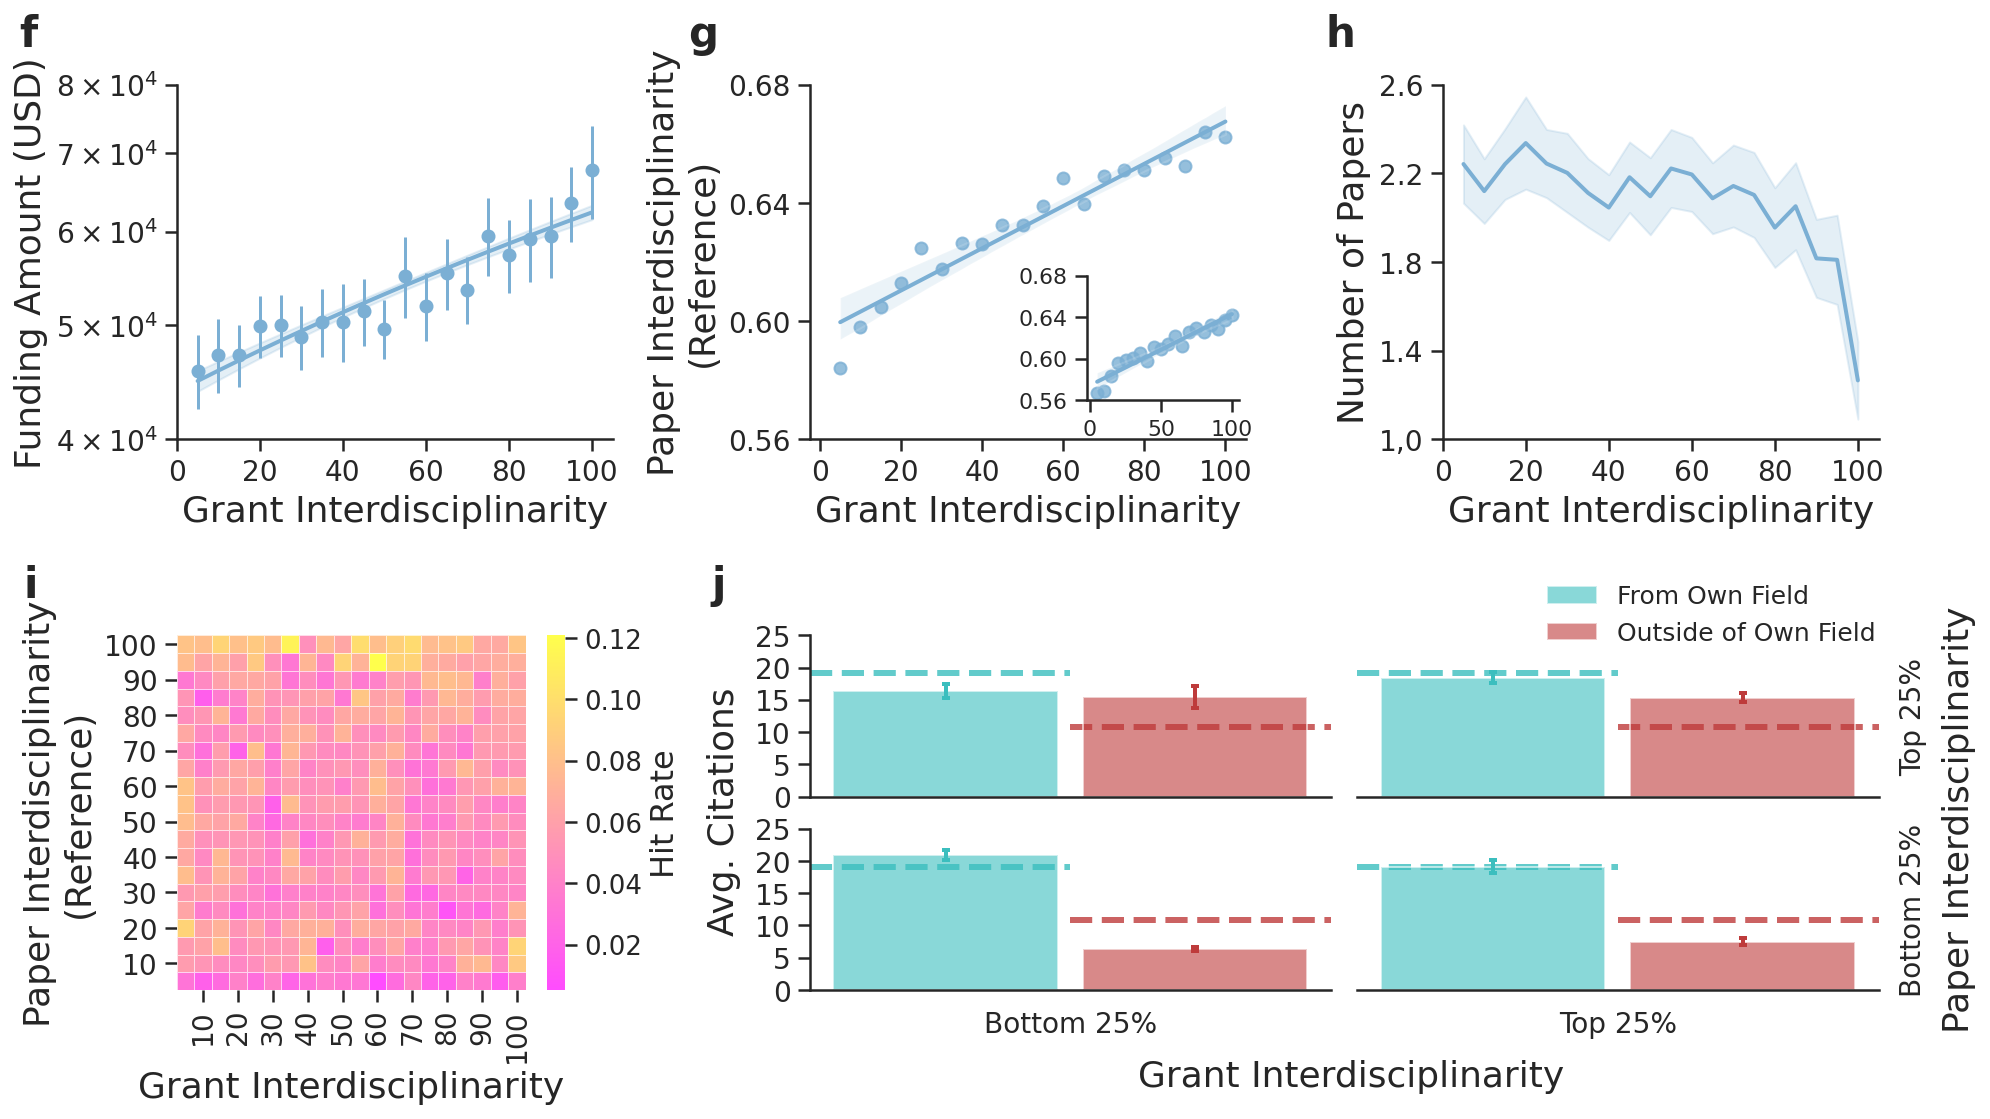

In [71]:
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['agg.path.chunksize'] = 10000

fig = plt.figure(figsize=(14,8))
gs = GridSpec(2, 3, figure=fig)

#####----- F -----#####
ax = fig.add_subplot(gs[0,0])

x1 = funding_per_grantITD_CN['grant_interdisciplinarity_interval']
mu1 = funding_per_grantITD_CN['funding_usd_mean']
ci1 = funding_per_grantITD_CN['funding_usd_ci']
ax.errorbar(x1, mu1, yerr=ci1, fmt='o', color='#7bafd4')

x2 = pred_y_CN['grant_interdisciplinarity_interval']
mu2 = pred_y_CN['mean_mean']
ci2 = pred_ci_CN['mean_se_mean']
ax.plot(x2, mu2, lw=2, color='#7bafd4')
ax.fill_between(x2, mu2+ci2, mu2-ci2, alpha=0.2, color='#7bafd4')

ax.set_ylabel('Funding Amount (USD)', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.yticks([4.0*10**4, 5.0*10**4, 6.0*10**4, 7.0*10**4, 8.0*10**4])
# ax.set_yticklabels(['2 x $10^5$', '3 x $10^5$', '4 x $10^5$', '5 x $10^5$', '6 x $10^5$', '7 x $10^5$'])
# plt.ylim(2.0*10**5, 7.0*10**5)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.32, 1.2, 'f', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- G -----#####
ax = fig.add_subplot(gs[0,1])

ax = sns.regplot(ax=ax, x='grant_interdisciplinarity_interval', y='interdisciplinarity_reference_mean',
                 line_kws={'linewidth':2}, color='#7bafd4', data=paperRefITD_per_grantITD_CN)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.gca().yaxis.set_major_locator(MultipleLocator(0.04))
plt.ylim(0.56, 0.68)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(-2.5, 105)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axins = inset_axes(ax, width="35%", height="35%", loc=4, 
                   bbox_to_anchor=(0.01,0.08,1,1), bbox_transform=ax.transAxes)
axins = sns.regplot(ax=axins, x='grant_interdisciplinarity_interval', y='interdisciplinarity_citation_mean', 
                    line_kws={'linewidth':2}, color='#7bafd4', data=paperCitITD_per_grantITD_CN)
axins.set_ylabel('')
axins.set_xlabel('')

plt.gca().yaxis.set_major_locator(MultipleLocator(0.04))
plt.ylim(0.56, 0.68)
plt.gca().xaxis.set_major_locator(MultipleLocator(50))
plt.xlim(-2.5, 105)
    
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'g', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- H -----#####
ax = fig.add_subplot(gs[0,2])

x = numPaper_per_grantITD_CN['grant_interdisciplinarity_interval']
mu = numPaper_per_grantITD_CN['num_paper_mean']
ci = numPaper_per_grantITD_CN['num_paper_ci']

ax.plot(x, mu, lw=2, color='#7bafd4')
ax.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#7bafd4')

plt.yticks([1.0, 1.4, 1.8, 2.2, 2.6])
ax.set_yticklabels(['1,0', '1.4', '1.8', '2.2', '2.6'])
plt.ylim(1.0, 2.6)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)

ax.set_ylabel('Number of Papers', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.2, 1.2, 'h', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- I -----#####
ax = fig.add_subplot(gs[1,0])

f1 = lambda x: None
f2 = lambda x: x
ax = sns.heatmap(df_heatmap_CN, cmap='spring', linewidth=0.5, alpha=0.7,
                 #xticklabels=[f(x) for x in range(10,100+1,10) for f in (f1,f2)],
                 #yticklabels=[f(x) for x in range(100,10-1,-10) for f in (f2,f1)],
                 cbar_kws={'label': 'Hit Rate'})

ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=90)
ax.set_xticks(np.arange(0, df_heatmap_CN.shape[0], 2)+1.5)
ax.set_yticks(np.arange(0, df_heatmap_CN.shape[0], 2)+0.5)
ax.set_xticklabels([x for x in range(10,100+1,10)])
ax.set_yticklabels([x for x in range(100,10-1,-10)])

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.text(-0.4, 1.2, 'i', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- J -----#####
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,1:3], hspace=0.2, wspace=0.05)
ax00 = plt.subplot(gs0[0,0])
ax01 = plt.subplot(gs0[0,1])
ax10 = plt.subplot(gs0[1,0])
ax11 = plt.subplot(gs0[1,1])

c1,c2 = '#3bbebe','#be3b3b'
barWidth = 0.9

df_tmp = c_per_grantITD_paperITD_FromOwnField_CN[c_per_grantITD_paperITD_FromOwnField_CN['label_avg_grant_itd_n_paper_itd']=='25&100']
ax00.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax00.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax00.axhline(rand_inside_CN, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax00.axhline(rand_outside_CN, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax00.axis(ymin=0,ymax=25)
ax00.set_yticks([0, 5, 10, 15, 20, 25])
ax00.set_yticklabels(['0', '5', '10', '15', '20', '25'])
ax00.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=14,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField_CN[c_per_grantITD_paperITD_FromOwnField_CN['label_avg_grant_itd_n_paper_itd']=='100&100']
ax01.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0], label='From Own Field',
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax01.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1], label='Outside of Own Field',
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax01.axhline(rand_inside_CN, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax01.axhline(rand_outside_CN, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax01.axis(ymin=0,ymax=25)
ax01.set_ylabel('Top 25%', fontsize=14, labelpad=10)
ax01.yaxis.set_label_position('right')
ax01.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
ax01.legend(loc='lower left', bbox_to_anchor=(0.32, 0.8),
            fontsize=12.5, frameon=False)
ax01.spines['top'].set_visible(False)
ax01.spines['right'].set_visible(False)
ax01.spines['left'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField_CN[c_per_grantITD_paperITD_FromOwnField_CN['label_avg_grant_itd_n_paper_itd']=='25&25']
ax10.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax10.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax10.axhline(rand_inside_CN, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax10.axhline(rand_outside_CN, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax10.axis(ymin=0,ymax=25)
ax10.set_yticks([0, 5, 10, 15, 20, 25])
ax10.set_yticklabels(['0', '5', '10', '15', '20', '25'])
ax10.set_xlabel('Bottom 25%', fontsize=14, labelpad=10)
ax10.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=14,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField_CN[c_per_grantITD_paperITD_FromOwnField_CN['label_avg_grant_itd_n_paper_itd']=='100&25']
ax11.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax11.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax11.axhline(rand_inside_CN, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax11.axhline(rand_outside_CN, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax11.axis(ymin=0,ymax=25)
ax11.set_xlabel('Top 25%', fontsize=14, labelpad=10)
ax11.set_ylabel('Bottom 25%', fontsize=14, labelpad=10)
ax11.yaxis.set_label_position('right')
ax11.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.text(-1.425, -15, 'Grant Interdisciplinarity', size=18)
ax11.text(1.8, -5.55, 'Paper Interdisciplinarity', size=18, rotation=90)
ax11.text(-3.15, 9.5, 'Avg. Citations', size=18, rotation=90)
ax11.text(1.575, 1.2, 'j', transform=ax.transAxes,
          fontsize=21, fontweight='bold', va='top', ha='right')


#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/supp_fig-9b.pdf', format='pdf', dpi=700, bbox_inches='tight')

## Other Countries

- US (62.9%), JP (11.2%), CN (8.8%), GB (3.9%), BE (3.9%) // RU (2.8%), CZ (1.5%)
- Each of these countries accounts for more than 10,000 // 5,000 grants paired with at least one paper outcome.

<ipython-input-34-6b071f71b72c>:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


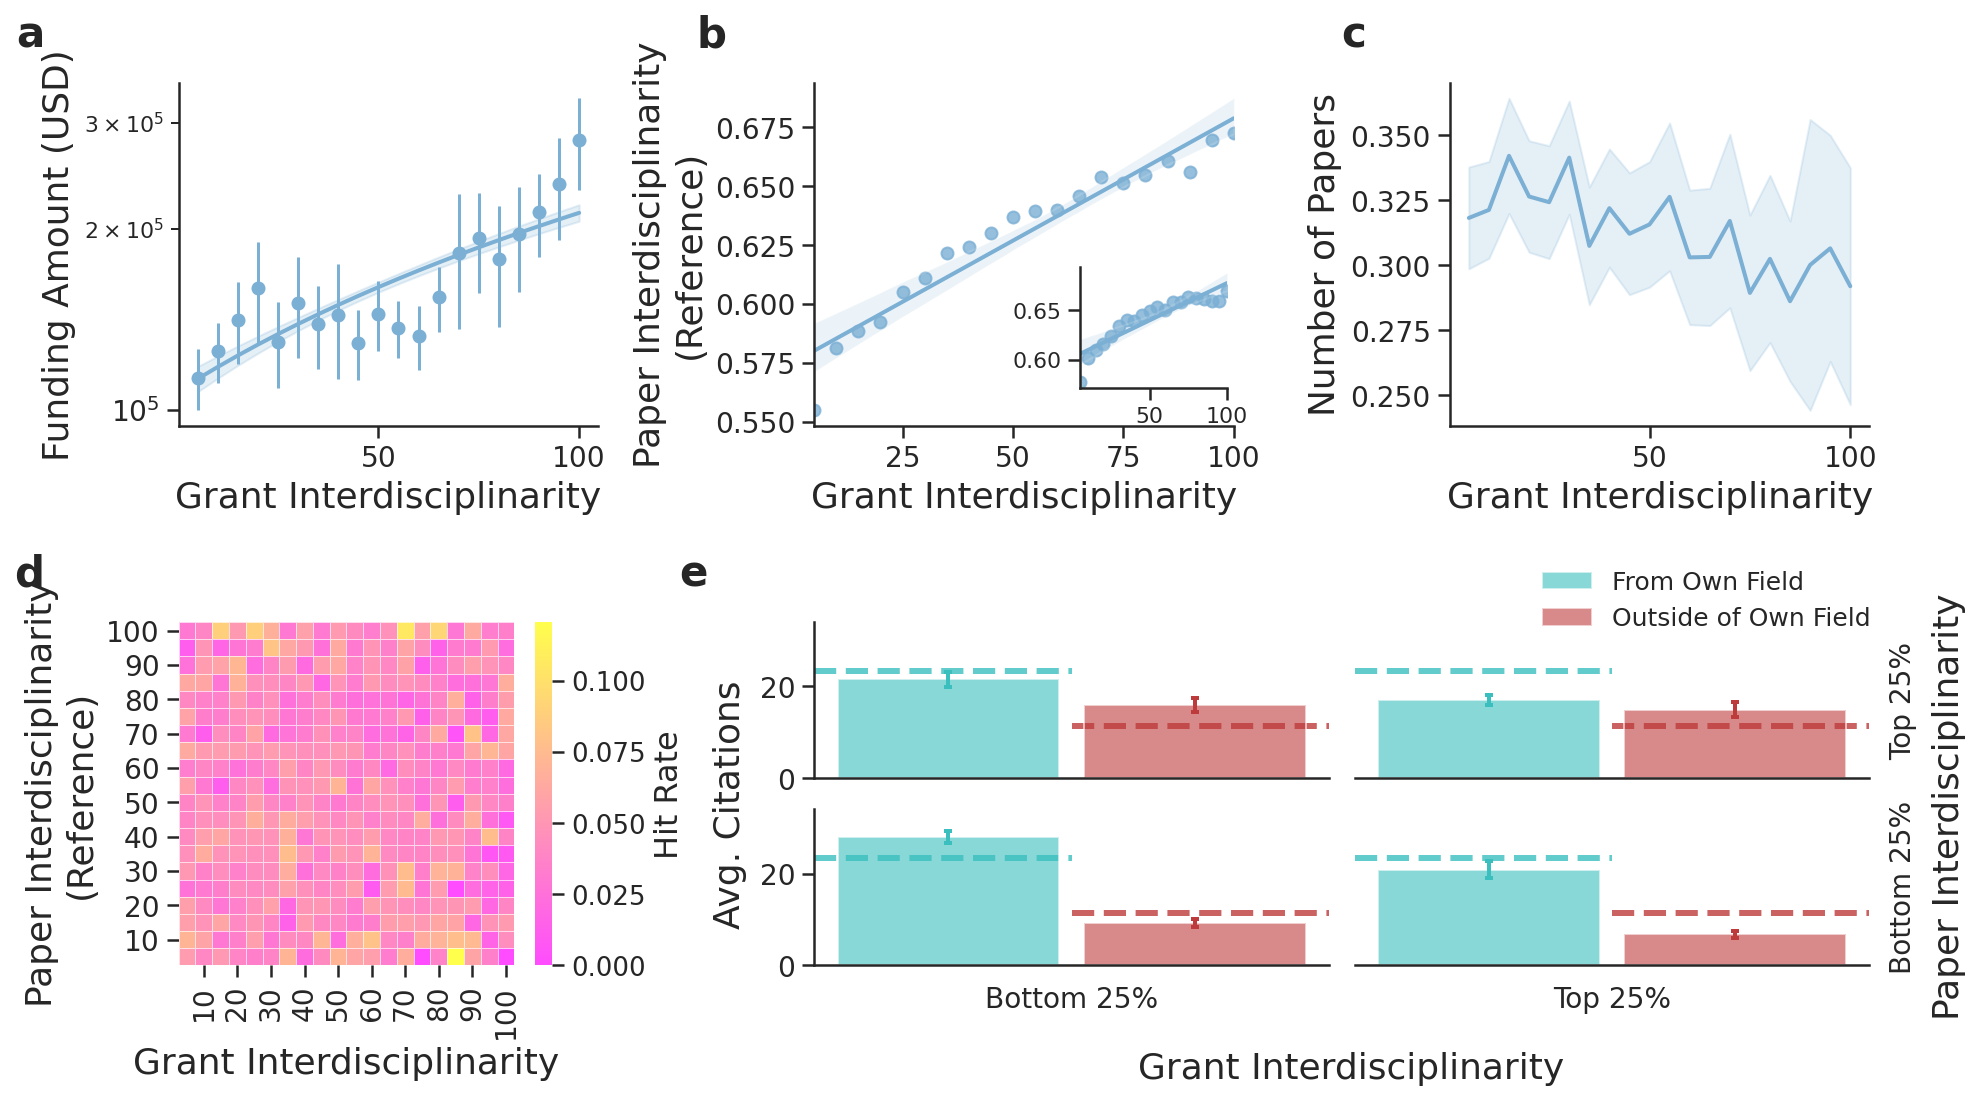

<ipython-input-34-6b071f71b72c>:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


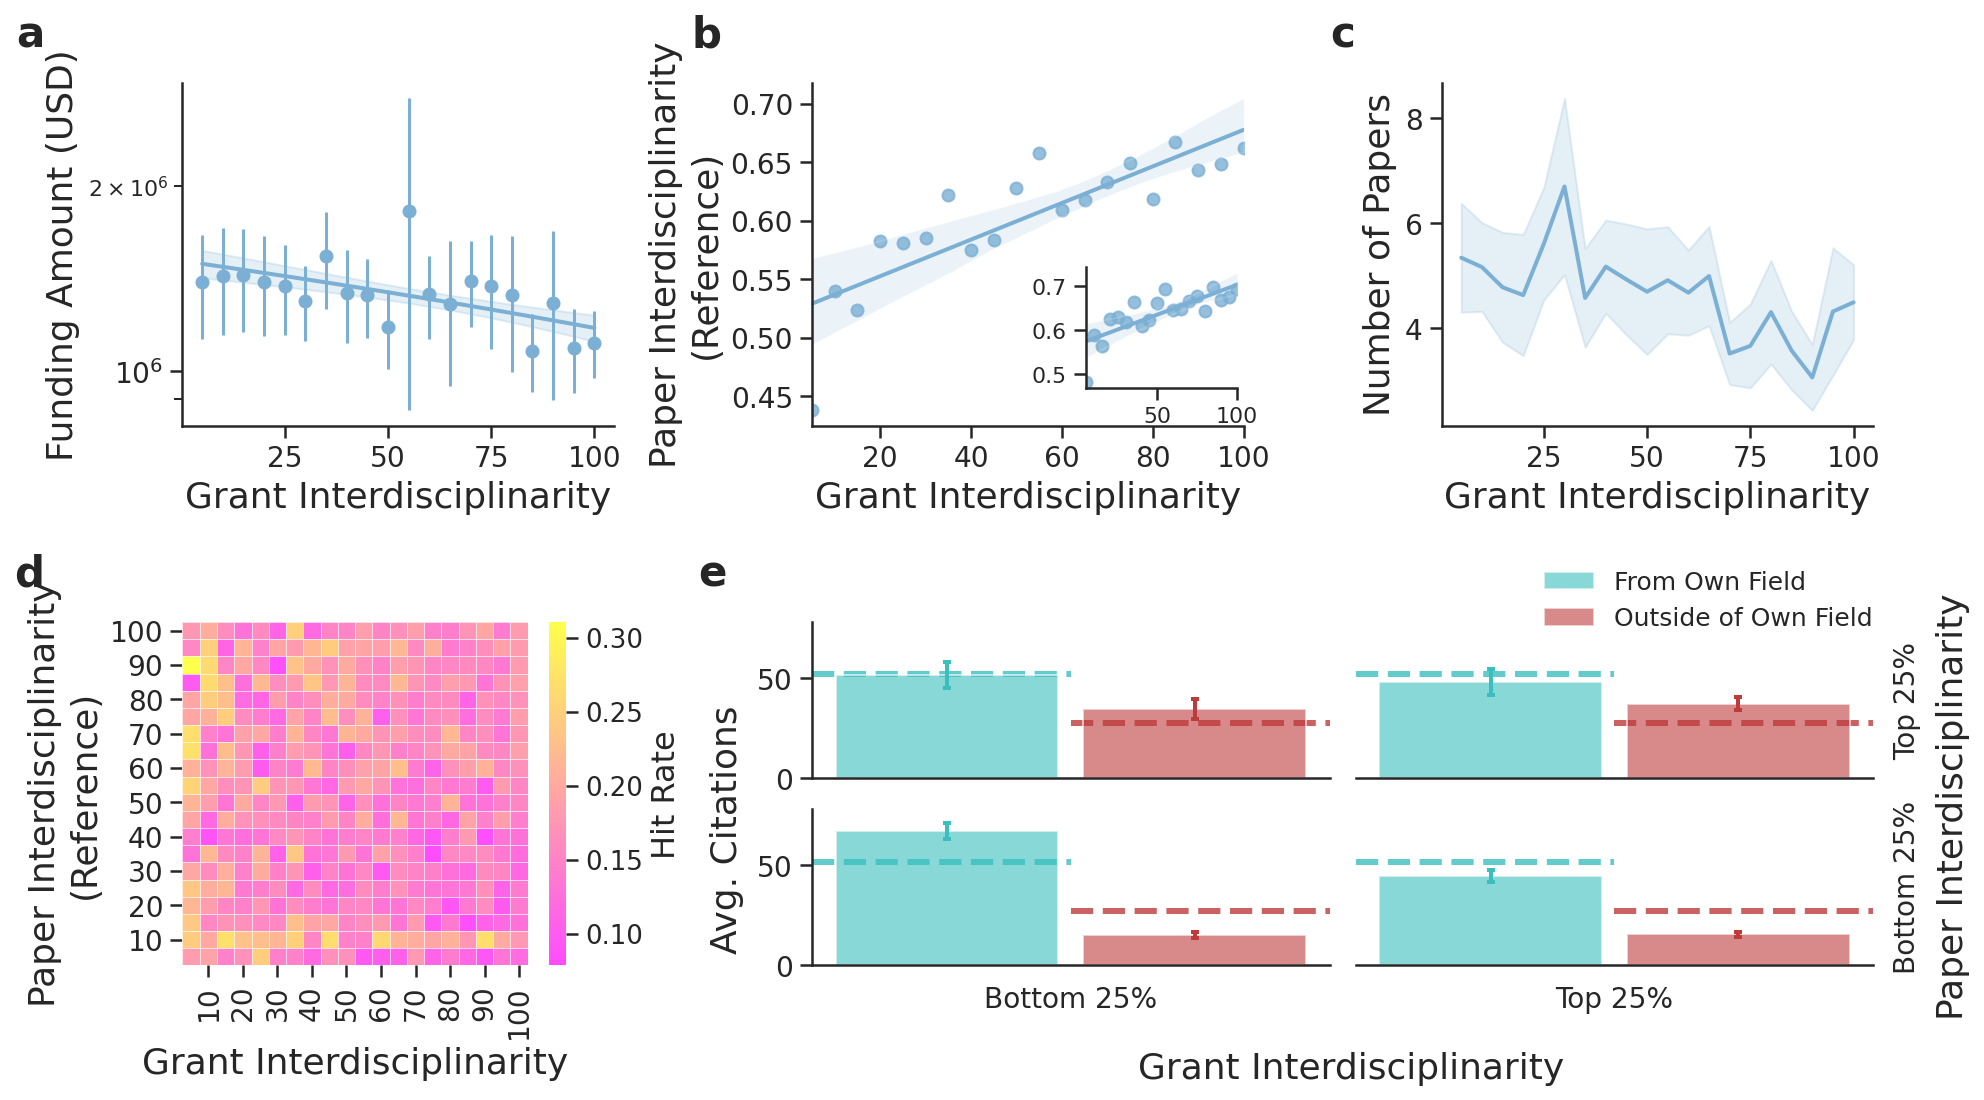

<ipython-input-34-6b071f71b72c>:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


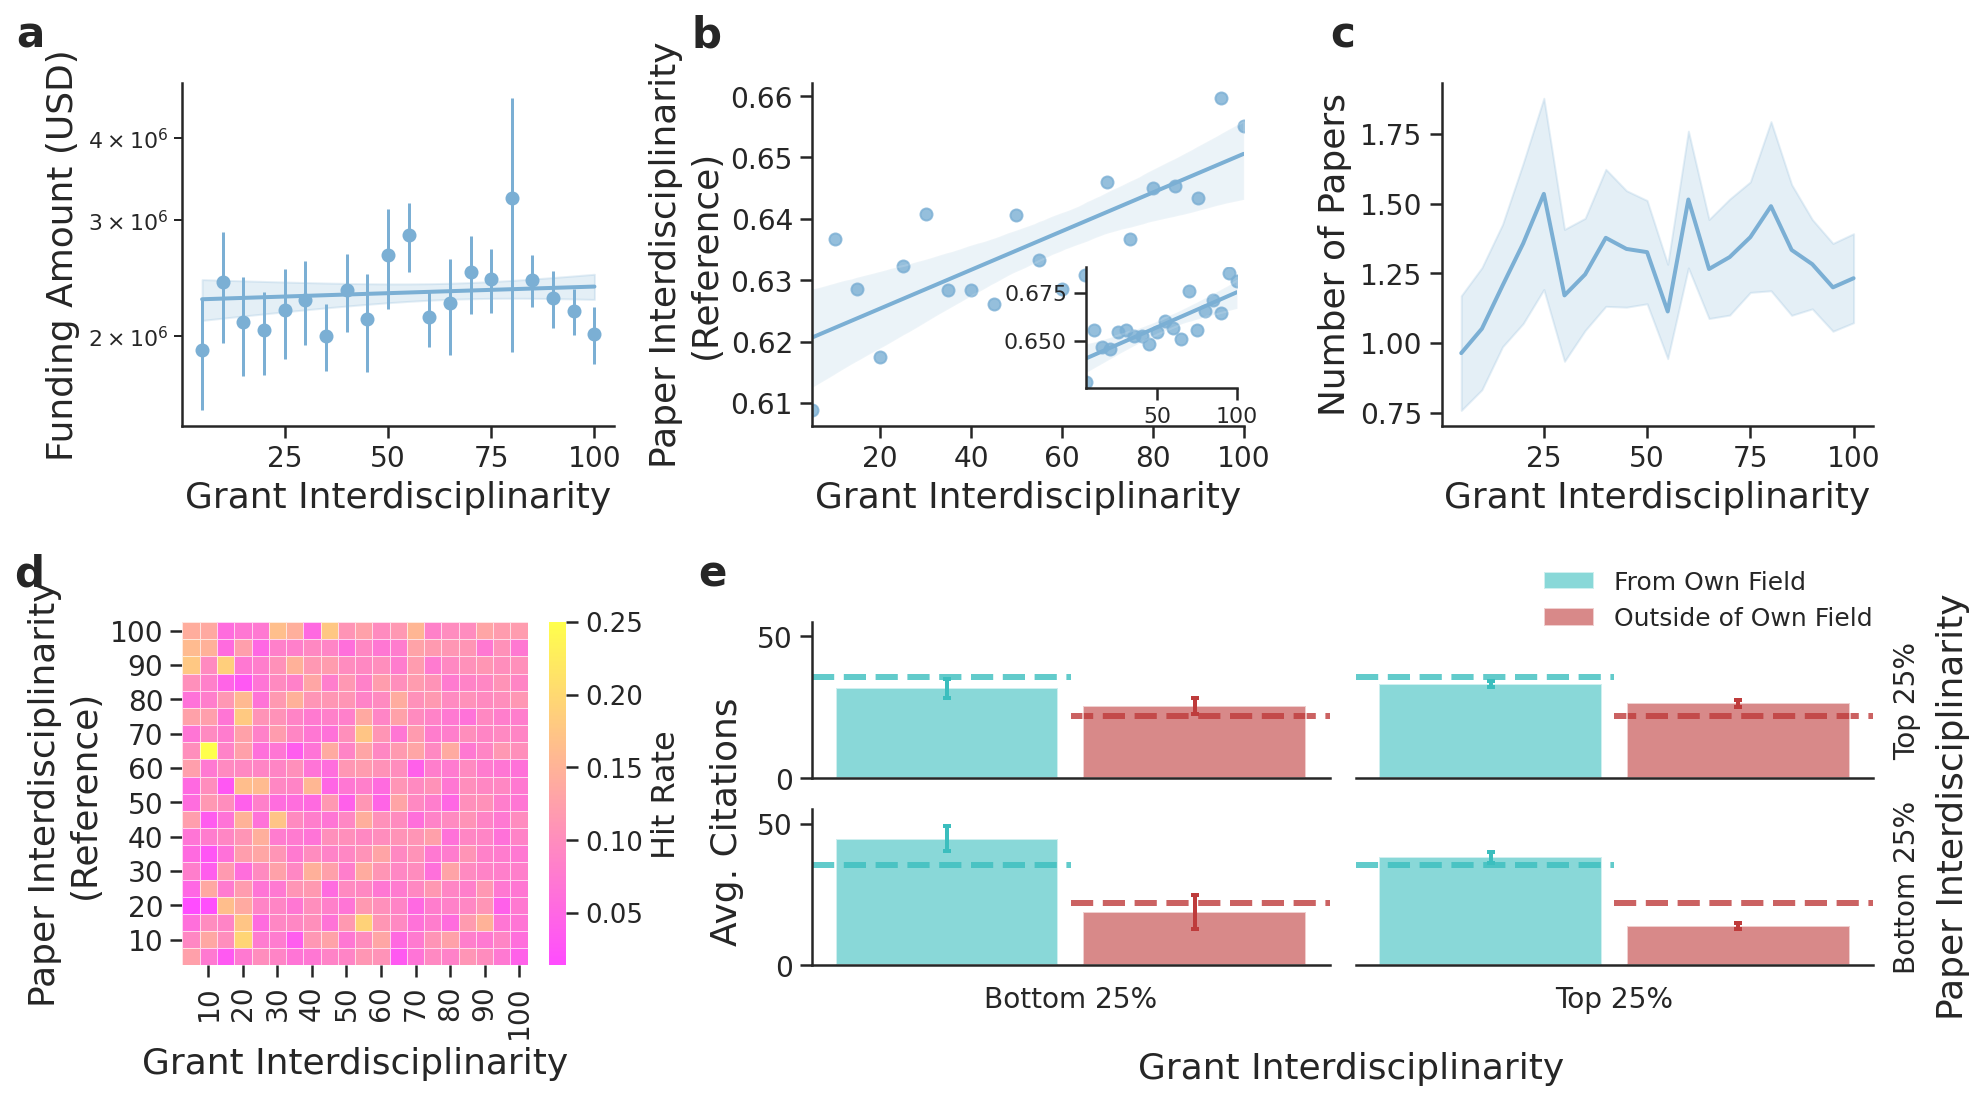

In [34]:
import statsmodels.api as sm
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['agg.path.chunksize'] = 10000


l_country = ['JP','GB','BE']

for country in l_country:
    df_pair = df_pair_1985_2009[df_pair_1985_2009["funder_countries"]==country]
    df_grant = df_grant_1985_2009[df_grant_1985_2009["funder_countries"]==country]
    
    pd.options.mode.chained_assignment = None  # default='warn'
    df_pair['mag_id'] = df_pair['mag_id'].astype(str)
    
    #####----- a -----#####
    df_tmp = df_pair[['grant_id','funding_usd','grant_interdisciplinarity_interval']].drop_duplicates()
    funding_per_grantITD = summarySE(df_tmp, ['funding_usd'], ['grant_interdisciplinarity_interval'])

    X = sm.add_constant(df_tmp['grant_interdisciplinarity_interval'])
    ols_model = sm.OLS(df_tmp['funding_usd'], X, missing='drop')
    est = ols_model.fit()
    out = est.conf_int(alpha=0.05, cols=None)

    pred = est.get_prediction(X).summary_frame()
    pred['grant_interdisciplinarity_interval'] = df_tmp['grant_interdisciplinarity_interval']
    pred['ci'] = pred['mean_se']*1.96
    pred_y = summarySE(pred, ['mean'], ['grant_interdisciplinarity_interval'])
    pred_ci = summarySE(pred, ['mean_se'], ['grant_interdisciplinarity_interval'])

    #####----- b -----#####
    df_tmp = df_pair[['interdisciplinarity_reference','interdisciplinarity_citation','grant_interdisciplinarity_interval']]
    paperRefITD_per_grantITD = summarySE(df_tmp, ['interdisciplinarity_reference'], ['grant_interdisciplinarity_interval'])
    paperCitITD_per_grantITD = summarySE(df_tmp, ['interdisciplinarity_citation'], ['grant_interdisciplinarity_interval'])

    #####----- c -----#####
    df_tmp = df_grant[['grant_id','grant_interdisciplinarity_interval','num_paper']].drop_duplicates()
    numPaper_per_grantITD = summarySE(df_tmp, ['num_paper'], ['grant_interdisciplinarity_interval'])

    #####----- d -----#####
    df_tmp = df_pair[['grant_interdisciplinarity_interval','interdisciplinarity_reference_interval',
                      'c_hit_rate_5_lvl-0']].groupby(['grant_interdisciplinarity_interval',
                                                      'interdisciplinarity_reference_interval'], as_index=False).mean()
    df_heatmap = df_tmp.pivot('interdisciplinarity_reference_interval','grant_interdisciplinarity_interval',
                                  'c_hit_rate_5_lvl-0')

    df_heatmap.sort_index(level=0, ascending=False, inplace=True)

    #####----- e -----#####
    df_tmp = df_paper_grant_stat[(((df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==25)|
                                   (df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==100)) &
                                  ((df_paper_grant_stat['interdisciplinarity_reference_quartile']==25)|
                                   (df_paper_grant_stat['interdisciplinarity_reference_quartile']==100)))].copy()

    df_tmp[['mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']] = df_tmp[['mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']].astype(str)
    df_tmp['label_avg_grant_itd_n_paper_itd'] = df_tmp[['mean_grant_interdisciplinarity_quartile',
                                                        'interdisciplinarity_reference_quartile']].agg('&'.join, axis=1)

    df_tmp = df_tmp[df_tmp['mag_id'].isin(df_pair['mag_id'])]

    df_c_from_own_fos['mag_id'] = df_c_from_own_fos['mag_id'].astype(str)
    df_tmp = pd.merge(df_c_from_own_fos, df_tmp, on='mag_id')

    df_tmp = df_tmp[['label_io', 'c_from_own_fos', 'label_avg_grant_itd_n_paper_itd',
                     'mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']]

    c_per_grantITD_paperITD_FromOwnField = summarySE(df_tmp, ['c_from_own_fos'],
                                                     ['label_io','label_avg_grant_itd_n_paper_itd'])

    df_rand = summarySE(df_tmp, ['c_from_own_fos'], ['label_io'])
    rand_inside = float(df_rand[df_rand['label_io']=='Inside']['c_from_own_fos_mean'])
    rand_outside = float(df_rand[df_rand['label_io']=='Outside']['c_from_own_fos_mean'])
    lim_yaxis = int(max(c_per_grantITD_paperITD_FromOwnField['c_from_own_fos_mean']) +\
                    max(c_per_grantITD_paperITD_FromOwnField['c_from_own_fos_ci']) + 5)
    
    
    #####-------------#####
    
    
    fig = plt.figure(figsize=(14,8))
    gs = GridSpec(2, 3, figure=fig)

    #####----- a -----#####
    ax = fig.add_subplot(gs[0,0])

    x1 = funding_per_grantITD['grant_interdisciplinarity_interval']
    mu1 = funding_per_grantITD['funding_usd_mean']
    ci1 = funding_per_grantITD['funding_usd_ci']
    ax.errorbar(x1, mu1, yerr=ci1, fmt='o', color='#7bafd4')

    x2 = pred_y['grant_interdisciplinarity_interval']
    mu2 = pred_y['mean_mean']
    ci2 = pred_ci['mean_se_mean']
    ax.plot(x2, mu2, lw=2, color='#7bafd4')
    ax.fill_between(x2, mu2+ci2, mu2-ci2, alpha=0.2, color='#7bafd4')

    ax.set_ylabel('Funding Amount (USD)', fontsize=18)
    ax.set_yscale('log')
    ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.32, 1.2, 'a', transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='right')



    #####----- b -----#####
    ax = fig.add_subplot(gs[0,1])

    ax = sns.regplot(ax=ax, x='grant_interdisciplinarity_interval', y='interdisciplinarity_reference_mean',
                     line_kws={'linewidth':2}, color='#7bafd4', data=paperRefITD_per_grantITD)
    ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
    ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    axins = inset_axes(ax, width="35%", height="35%", loc=4, 
                       bbox_to_anchor=(0.01,0.08,1,1), bbox_transform=ax.transAxes)
    axins = sns.regplot(ax=axins, x='grant_interdisciplinarity_interval', y='interdisciplinarity_citation_mean', 
                        line_kws={'linewidth':2}, color='#7bafd4', data=paperCitITD_per_grantITD)
    axins.set_ylabel('')
    axins.set_xlabel('')

    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)
    ax.text(-0.21, 1.2, 'b', transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='right')



    #####----- c -----#####
    ax = fig.add_subplot(gs[0,2])

    x = numPaper_per_grantITD['grant_interdisciplinarity_interval']
    mu = numPaper_per_grantITD['num_paper_mean']
    ci = numPaper_per_grantITD['num_paper_ci']

    ax.plot(x, mu, lw=2, color='#7bafd4')
    ax.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#7bafd4')

    ax.set_ylabel('Number of Papers', fontsize=18)
    ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.2, 1.2, 'c', transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='right')



    #####----- d -----#####
    ax = fig.add_subplot(gs[1,0])

    f1 = lambda x: None
    f2 = lambda x: x
    ax = sns.heatmap(df_heatmap, cmap='spring', linewidth=0.5, alpha=0.7,
                     #xticklabels=[f(x) for x in range(10,100+1,10) for f in (f1,f2)],
                     #yticklabels=[f(x) for x in range(100,10-1,-10) for f in (f2,f1)],
                     cbar_kws={'label': 'Hit Rate'})

    ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
    ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.xticks(rotation=90)
    ax.set_xticks(np.arange(0, df_heatmap.shape[0], 2)+1.5)
    ax.set_yticks(np.arange(0, df_heatmap.shape[0], 2)+0.5)
    ax.set_xticklabels([x for x in range(10,100+1,10)])
    ax.set_yticklabels([x for x in range(100,10-1,-10)])

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)
    ax.figure.axes[-1].yaxis.label.set_size(16)
    ax.text(-0.4, 1.2, 'd', transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='right')



    #####----- e -----#####
    gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,1:3], hspace=0.2, wspace=0.05)
    ax00 = plt.subplot(gs0[0,0])
    ax01 = plt.subplot(gs0[0,1])
    ax10 = plt.subplot(gs0[1,0])
    ax11 = plt.subplot(gs0[1,1])

    c1,c2 = '#3bbebe','#be3b3b'
    barWidth = 0.9

    df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='25&100']
    ax00.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
             yerr=list(df_tmp['c_from_own_fos_ci'])[0],
             error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
    ax00.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
             yerr=list(df_tmp['c_from_own_fos_ci'])[1],
             error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
    ax00.axhline(rand_inside, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
    ax00.axhline(rand_outside, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
    ax00.axis(ymin=0,ymax=lim_yaxis)
    ax00.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        labelsize=14,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax00.spines['top'].set_visible(False)
    ax00.spines['right'].set_visible(False)

    df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='100&100']
    ax01.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
             yerr=list(df_tmp['c_from_own_fos_ci'])[0], label='From Own Field',
             error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
    ax01.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
             yerr=list(df_tmp['c_from_own_fos_ci'])[1], label='Outside of Own Field',
             error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
    ax01.axhline(rand_inside, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
    ax01.axhline(rand_outside, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
    ax01.axis(ymin=0,ymax=lim_yaxis)
    ax01.set_ylabel('Top 25%', fontsize=14, labelpad=10)
    ax01.yaxis.set_label_position('right')
    ax01.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelleft=False,
        labelbottom=False) # labels along the bottom edge are off
    ax01.legend(loc='lower left', bbox_to_anchor=(0.32, 0.8),
                fontsize=12.5, frameon=False)
    ax01.spines['top'].set_visible(False)
    ax01.spines['right'].set_visible(False)
    ax01.spines['left'].set_visible(False)

    df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='25&25']
    ax10.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
             yerr=list(df_tmp['c_from_own_fos_ci'])[0],
             error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
    ax10.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
             yerr=list(df_tmp['c_from_own_fos_ci'])[1],
             error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
    ax10.axhline(rand_inside, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
    ax10.axhline(rand_outside, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
    ax10.axis(ymin=0,ymax=lim_yaxis)
    ax10.set_xlabel('Bottom 25%', fontsize=14, labelpad=10)
    ax10.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        labelsize=14,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax10.spines['top'].set_visible(False)
    ax10.spines['right'].set_visible(False)

    df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='100&25']
    ax11.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
             yerr=list(df_tmp['c_from_own_fos_ci'])[0],
             error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
    ax11.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
             yerr=list(df_tmp['c_from_own_fos_ci'])[1],
             error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
    ax11.axhline(rand_inside, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
    ax11.axhline(rand_outside, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
    ax11.axis(ymin=0,ymax=lim_yaxis)
    ax11.set_xlabel('Top 25%', fontsize=14, labelpad=10)
    ax11.set_ylabel('Bottom 25%', fontsize=14, labelpad=10)
    ax11.yaxis.set_label_position('right')
    ax11.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelleft=False,
        labelbottom=False) # labels along the bottom edge are off
    ax11.spines['top'].set_visible(False)
    ax11.spines['right'].set_visible(False)
    ax11.spines['left'].set_visible(False)
    ax11.text(-1.425, -lim_yaxis*0.725, 'Grant Interdisciplinarity', size=18)
    ax11.text(1.8, -lim_yaxis*0.3, 'Paper Interdisciplinarity', size=18, rotation=90)
    ax11.text(-3.15, 9.5, 'Avg. Citations', size=18, rotation=90)
    ax11.text(1.575, 1.2, 'e', transform=ax.transAxes,
              fontsize=21, fontweight='bold', va='top', ha='right')


    #####-------------#####
    plt.tight_layout()
    plt.show()